# Problema de regresión

## Descripción del problema

En este problema vamos a trabajar con el conjunto de datos _Airfoil Self-Noise_, el cuál ha sido proporcionado por la NASA, y contiene los resultados de haber realizado un conjunto de pruebas aerodinámicas y acústicas en un túnel de viento sobre perfiles alares de dos y tres dimensiones.

El conjunto de datos está compuesto por 1503 filas y 6 columnas, los valores de las cuáles son todos números reales. Los datos de las 5 primeras columnas se corresponden con los datos de entrada, y la última columna se corresponde con la información de salida. A continuación se puede ver que representa cada uno de los atributos de forma ordenada:

1. Frecuencia, medida en $Hz$.
2. Ángulo de ataque (ángulo que forman la cuerda geométrica de un perfil alar con la dirección del aire incidente), medida en grados.
3. Longitud de la cuerda del perfil alar, medida en metros.
4. Velocidad _free-stream_, medida en metros por segundo. 
5. Distancia de desplazamiento de succión, medida en metros.
6. Nivel de presión sonora, medida en $dB$.

## Análisis de los datos

Antes de comenzar con todo el proceso de elección y selección de un modelo lineal, vamos a pararnos un momento para analizar los datos de los que disponemos con el fin de obtener más información sobre el problema.

Lo primero que tenemos que hacer es cargar los datos. Para ello, vamos a usar una función genérica que nos permita leer ficheros de datos y obtener un _DataFrame_ que podamos usar luego. Vamos a ver como sería esta función:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Establecer la semilla que vamos a utilizar
np.random.seed(1)

def read_data_values(in_file, separator=None):
    """
    Funcion para leer los datos de un archivo
    
    :param in_file Archivo de entrada
    :param separator Separador que se utiliza en el archivo (por defecto
                     None)
    
    :return Devuelve los datos leidos del archivo en un DataFrame
    """
    
    # Cargar los datos en un DataFrame
    # Se indica que la primera columna no es el header
    if separator == None:
        df = pd.read_csv(in_file, header=None)
    else:
        df = pd.read_csv(in_file, sep=separator, header=None)
    
    return df

Con la función ya mostrada, vamos a cargar los datos y mostrar los primeros valores de la muestra, para tener una idea de como serán los datos:

In [2]:
df = read_data_values('datos/airfoil_self_noise.dat', separator='\t')

# Asignamos nombres a las columnas (según los atributos)
column_names = ['Frequency', 'Angle of attack', 'Chord length',
                'Free-stream velocity', 'SSD thickness', 'Sound Pressure']
df.columns = column_names

# Mostrar primeros valores de los datos
df.head()

,Frequency,Angle of attack,Chord length,Free-stream velocity,SSD thickness,Sound Pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


Antes de proseguir, vamos a dividir los datos en los conjuntos de training y test, ya que en este caso disponemos solo de un conjunto de datos (no viene separado por defecto). Para esto, vamos a crear primero una función que nos permita dividir los datos que tenemos en las características (a lo que llamaremos $\mathbf{X}$) y las etiquetas (a lo que llamaremos $y$). Una vez hecha esta separación, podremos dividir los datos en los dos conjuntos anteriormente mencionados. Vamos a hacer que el 80% de los datos se quede en training y que el 20% de los datos esté en test. Por tanto, en resumidas cuentas, estamos haciendo _hold-out_, ya que nos quedamos con una parte de los datos para poder estimar un E$_{test}$ que nos permita acotar E$_{out}$ posteriormente. Esto tiene sus efectos negativos, como que por ejemplo tengamos menos datos con los que entrenar y que los resultados pueden ser un poco peores por este motivo, pero al menos tenemos una capacidad para probar como de bueno es nuestro ajuste fuera de la muestra con la que lo hemos entrenado.

Con esto dicho, vamos a ver como ser haría:

In [3]:
# Función para dividir los datos en train y test
from sklearn.model_selection import train_test_split

def divide_data_labels(input_data):
    """
    Funcion que divide una muestra en los datos y las etiquetas
    
    :param input_data Conjunto de valores que se quieren separar
                      juntados en un DataFrame
    
    :return Devuelve los datos y las etiquetas
    """
    
    #Obtener los valores
    values = input_data.values
    
    # Obtener datos y etiquetas
    X = values[:, :-1]
    y = values[:, -1]
    
    return X, y

# Obtener valores X, Y
X, y = divide_data_labels(df)

# Dividir los datos en training y test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                test_size=0.2, random_state=1, shuffle=True)

Con los datos ya cargados y divididos en los conjuntos de training y test, vamos a obtener cierta información
sobre éstos. En problemas de este tipo nos interesa conocer por ejemplo si en ciertos casos faltan datos (no se ha podido obtener información sobre todos los atributos debido a que es imposible hacerlo, han habido errores a la hora de tomarlos o no se disponía de las herramientas necesarias), el número de valores distintos, los rangos de los datos (valores mínimos y máximos para cada atributo), si existe algún tipo de correlación entre las variables, etc.

Vamos a comenzar estudiando primero las características más simples, para adentrarnos luego en el estudio de la correlación. Empecemos mirando información del conjunto training:

In [4]:
# Clase para mostrar información de DataFrames resumida
from pandas_summary import DataFrameSummary
from IPython.core.display import display

# Crear información resumida sobre los datos de training
train_df = pd.DataFrame(columns=column_names,
                        data=np.c_[X_train, y_train])

# Crear un DataFrame de resumen y mostrarlo
train_sum = DataFrameSummary(train_df).summary()
display(train_sum)

,Frequency,Angle of attack,Chord length,Free-stream velocity,SSD thickness,Sound Pressure
count,1202,1202,1202,1202,1202,1202
mean,2966.26,6.73569,0.136403,50.941,0.0111494,124.852
std,3246.55,5.9433,0.0934083,15.605,0.0132485,6.9909
min,200,0,0.0254,31.7,0.000400682,103.38
25%,800,2,0.0508,39.6,0.00251435,120.1
50%,2000,5.3,0.1016,39.6,0.00495741,125.821
75%,4000,10.875,0.2286,71.3,0.0150478,130.071
max,20000,22.2,0.3048,71.3,0.0584113,140.987
counts,1202,1202,1202,1202,1202,1202
uniques,21,27,6,4,105,1169


Aquí podemos ver que para ninguna de las variables faltan datos, lo cuál nos ahorra tiempo extra de procesado en el que tendríamos que insertar valores a partir de algún valor estadístico (valores medios, por ejemplo).

También podemos ver información sobre como varían los datos, tanto los de entrada como los de salida. Vemos que, por ejemplo, **Frequency** es una característica que varía mucho, ya que tiene unos valores mínimos y máximos muy dispares, además de tener una desviación típica muy elevada. Posiblemente este atributo contenga _outliers_, pero al no disponer de demasiados datos, y al ser tan pocos los posibles valores anómalos, no merece la pena intentar eliminarlos. Observando el resto de características, nos encontramos con unos valores que varían menos y cuyos rangos de valores más pequeño. Lo sorprendente es que, para los datos de entrada, tenemos que hay muy pocos valores únicos (no repetidos). Esto se puede deber a que no se han medido los valores con suficiente precisión o a que no exista una verdadera variabilidad entre ellos. Para los datos de salida, en cambio, nos encontramos que hay un montón de valores distintos. Esto es normal, ya que, al ser valores reales, hay muchos posibles valores. De aquí podemos concluir que, a pesar de que nos encontremos ante un problema con variable reales, parece que los
valores que toman las variables de entrada están discretizados, es decir, que no son exactamente contínuos.

Pasemos ahora a analizar el conjunto de datos de entrenamiento. Para obtener suficiente información, vamos a fijarnos solo en valores únicos y si faltan datos, teniendo en cuenta que nunca debemos obtener información completa sobre los datos de test, ya que se supone que nunca serán conocidos y que nunca deberíamos verlos. A continuación, podemos ver esta información:

In [5]:
# Crear DataFrame con los datos de test
test_df = pd.DataFrame(columns=column_names,
                       data=np.c_[X_test, y_test])

# Crear un DataFrame resumen y mostrar algunos
# valores estadísticos
test_sum = DataFrameSummary(test_df).columns_stats
display(test_sum)

,Frequency,Angle of attack,Chord length,Free-stream velocity,SSD thickness,Sound Pressure
counts,301,301,301,301,301,301
uniques,20,27,6,4,97,300
missing,0,0,0,0,0,0
missing_perc,0%,0%,0%,0%,0%,0%
types,numeric,numeric,numeric,numeric,numeric,numeric


Como se puede ver, el número de valores únicos, para las variables de entrada, son muy próximos a los que teníamos anteriormente. En el caso de los valores de salida, podemos observar que hay mucha diversidad. Y, finalmente, como punto positivo, podemos ver que en ninguna de las muestras faltan datos.

Una vez hecho este pequeño análisis, pasemos a observar ahora la correlación entre las variables. Vamos a intentar obtener, para cada una de las variables (tanto las de entrada como las de salida) el coeficiente de correlación de Pearson. El resultado se puede ver a continuación:

In [6]:
# Obtener gráfica de correlación de Pearson
corr = train_df.corr()
corr.style.background_gradient(cmap='Spectral')

,Frequency,Angle of attack,Chord length,Free-stream velocity,SSD thickness,Sound Pressure
Frequency,1,-0.270796,-0.018266,0.122803,-0.233431,-0.395423
Angle of attack,-0.270796,1,-0.498267,0.0703666,0.754145,-0.159278
Chord length,-0.018266,-0.498267,1,-0.0241411,-0.22103,-0.23498
Free-stream velocity,0.122803,0.0703666,-0.0241411,1,-0.00863181,0.13866
SSD thickness,-0.233431,0.754145,-0.22103,-0.00863181,1,-0.314796
Sound Pressure,-0.395423,-0.159278,-0.23498,0.13866,-0.314796,1


Se puede ver que, en general, no existe una correlación entre la mayoría de las características. Sin embargo, sí que destacan dos casos, uno más que el otro. El primer caso es la relación que existe entre la característica **SSD thickness** y la característica **Angle of attack**. Estas dos características tienen una coeficiente de correlación de Pearson de $0.75$, valor que es muy próximo a $1$. Por tanto, podemos decir que existe cierta correlación entre ellas, ya que el crecimiento de una influirá en el crecimiento de la otra. Sin embargo, como el valor del coeficiente de Pearson no es 1, no podríamos asegurar con absoluta confianza que las 2 características estén correlacionadas, y que por tanto, sería necesario eliminar una de ellas. El segundo caso es **Chord length** y **Angle of attack**. Aquí lo que sucede es que el coeficiente de correlación de Pearson tiene un valor de aproximadamente $-0.5$. Con lo cuál, a pesar de que existe cierta correlación negativa entre las dos variables (cuando crezca una, la otra decrecerá), no podríamos afirmar con un 100% de confianza que estén totalmente correlacionadas, ya que el valor del coeficiente está en un punto medio.

Para tener una mejor visión de todo lo que se acaba a discutir, vamos a ver un conjunto de gráficas en las que se pueden ver los valores de todas las variables dos a dos (es decir, se muestran gráficas para mostrar como cambia cada par de variables, que pueden ser tanto las características como la etiqueta de salida). Esto se puede ver a continuación:

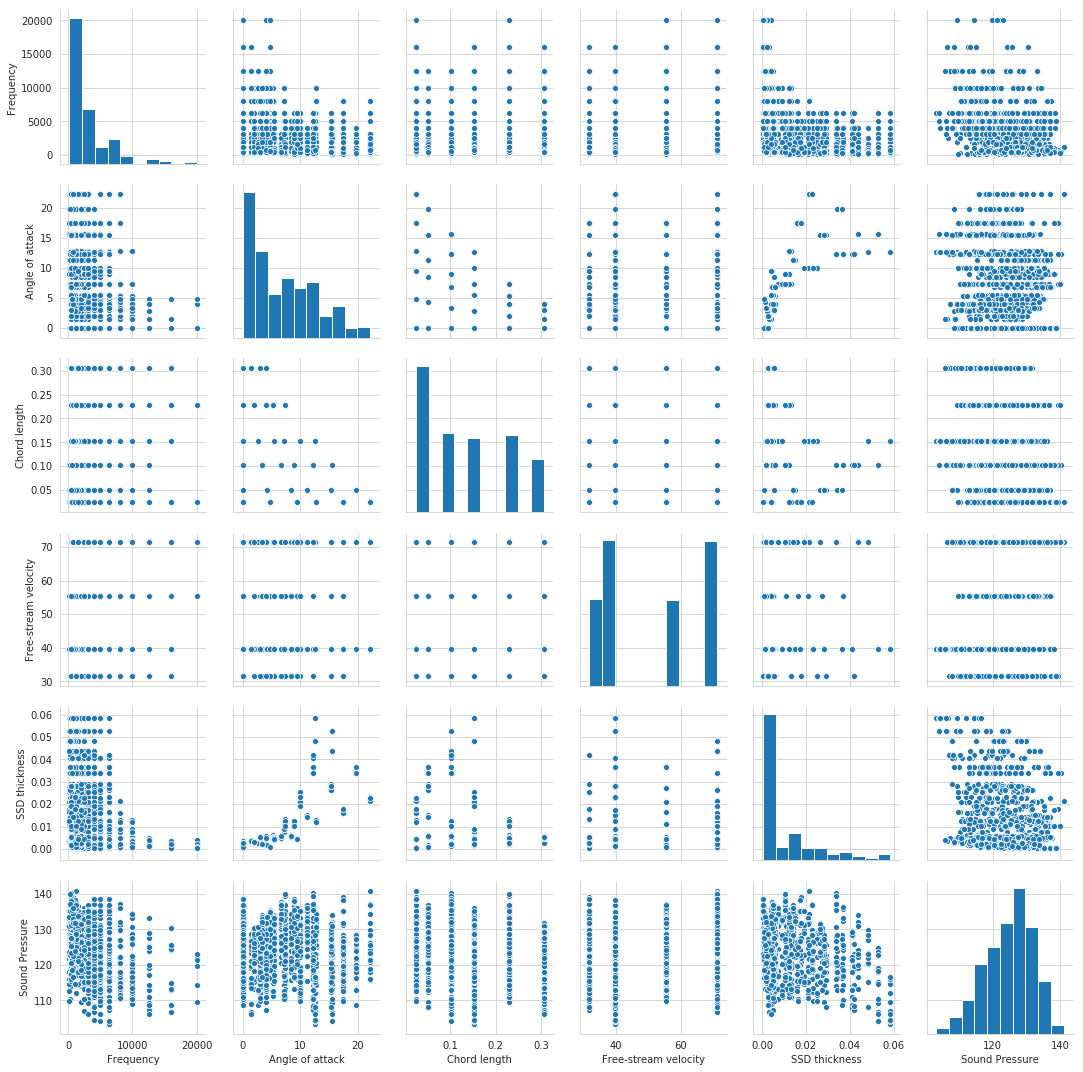

In [7]:
# Módulo avanzado para dibujar gráficas
import seaborn as sns

# Crear pares de plots para cada 2 atributos
# También se incluyen las etiquetas
sns.set_style("whitegrid")
sns.pairplot(train_df)

# Mostrar el plot
plt.show()

En estas gráficas se puede ver más claramente lo que se ha comentado anteriormente. Se puede ver, por ejemplo, como entre **SSD thickness** y **Angle of attack** existe cierta correlación, lo cuál confirma nuestra hipótesis anterior. Se puede ver, por ejemplo, en el gráfico en el que **SSD thickness** está en el eje $Y$ y **Angle of attack** en el $X$. Se puede observar que, a medida que va creciendo el valor de **SSD thickness**, parece que el otro va creciendo como si fuese un polinomio de grado 2. Cambiando los ejes de las variables, podemos ver que el crecimiento pasa a ser o bien logarítmico o bien una raíz cuadrada.

Estudiando el caso de **Chord length** y **Angle of attack**, se puede ver que en los dos casos, a medida que se va incrementando el valor de la variable situada en el eje $X$, la que se encuentra en el eje $Y$ va disminuyendo de una forma que parece lineal.

Además, gracias a esta visualización hemos descubierto otra posbile correlación entre 2 variables: la que puede existir entre **SSD thickness** y **Frequency**. Aquí pasa algo muy parecido al caso anterior. A medida que una va aumentando su valor en el eje $X$, la otra va disminuyendo su valor en el eje $Y$ de una forma que nos recuerda a un polinomio de grado 2. Esta correlación hubiese sido difícil de ver solo con la tabla de correlaciones que teníamos anteriormente, pero gracias a las gráficas se puede ver de una forma más clara.

Para acabar este apartado de análisis, a pesar de haber descubierto que pueden existir correlaciones entre algunas variables, de momento vamos a decidir **no eliminar ninguna de las variables de entrada**, ya que en este problema no tenemos muchas dimensiones y los datos provienen de una fuente fiable como por ejemplo sería la NASA, así que supondremos que han realizado un buen trabajo procesando los datos antes de hacerlos públicos.

## Selección de funciones

Antes de continuar con la elección de modelo, vamos a comentar algunos aspectos a tener en cuenta, como por ejemplo qué funciones vamos a utilizar.

Para este problema, dado que hay pocas dimensiones y con el objetivo de intentar evitar un posible sobreajuste si se aplica alguna transformación no lineal a los datos, vamos a utilizar alguna función que sea **combinación lineal** de éstos, además de que son las funciones más sencillas de probar a priori y se considera buena práctica intentar utilizar estas funciones de primeras. Por tanto, nuestro objetivo será encontrar una función $g$ que, al realizar una combinación lineal de los datos de entrada nos permita obtener un valor real de salida. En caso de ver que nuestra función lineal nos ofrece un E$_{test}$ malo, podríamos intentar utilizar alguna transformación no lineal, como por ejemplo añadir los cuadrados de las entradas, aunque en un principio no se hará esto.

## Selección de métricas

Otro aspecto que tenemos que comentar, antes de pasar a hablar de los modelos a evaluar, es la métrica que utilizaremos tanto a la hora de ajustar los distintos modelos como para evaluar los modelos y elegir el mejor de ellos.

### Métrica del ajuste

Todos los modelos utilizarán la *loss function* o métrica MSE (Mean Squared Error, error cuadrático o norma $\ell 2$) cuando sean ajustados. Esto se debe a que queremos penalizar más los errores que se alejen más de los valores reales que aquellos que se alejen solo un poco.

### Métrica de evaluación

Para evaluar los modelos, vamos a utilizar como métrica el MAE (Mean Absolute Error, error absoluto o normal $\ell 1$). El motivo de esto es que queremos ver cúanta variabilidad real hay en los valores predichos, sin penalizar ningún tipo de error más que otro, además de que es más fácilmente interpretable (se van acumulando todos los errores en vez de acumular los cuadrados de éstos).

## Selección de modelos a evaluar

Finalmente, vamos a describir los modelos que se quieren evaluar para poder elegir el mejor de ellos y el por qué de cada uno.

### Regresión lineal

El primer modelo que queremos evaluar es la regresión lineal, sin ningún tipo de regularización. Queremos evaluar su rendimiento respecto a modelos que intentan ofrecer mejores resultados mediante regularización o algo más complejos pero sin salir de los modelos lineales.

### *Ridge Regression*

El segundo modelo que queremos evaluar es la *Ridge Regressión*, o dicho de otra forma, regresión lineal con regularización de tipo norma $\ell 2$. Es decir, habría que resolver un problema de tipo:

\begin{equation}
\min_{w} || X w - y||_2^2 + \alpha ||w||_2^2
\end{equation}

Esta regularización, lo que hace, es añadir la suma de los cuadrados de cada uno de los $w_i \in w$, ponderada con un hiperparámetro $\alpha$ que se tiene que elegir.

El motivo por el que se ha escogido este modelo es porque se intenta mejorar la regresión lineal, restringiendo el espacio de soluciones para intentar evitar tanto el sobreajuste como resultados pobres. Es importante decir que se ha preferido utilizar *Ridge* como forma de regularización sobre *Lasso* (norma $\ell 1$) debido a que esta última busca reducir el número de características ponderando cuantas más pueda con un valor de $0$, cosa que no nos interesa en este problema ya que no disponemos de muchas variables.

### SVM con _kernel_ lineal

El último modelo que queremos evaluar es el SVM de regresión con *kernel* lineal, con el objetivo de ver si es capaz de ganarle a la regresión lineal normal y a la *Ridge Regression*. Esta es una técnica más avanzada y un poco más compleja que el SVM utilizado en clasificación, ya que aquí se tienen algunos parámetros más.

El objetivo aquí es intentar encontrar el mejor plano o uno muy bueno dentro de un margen (debido a que en problemas de regresión hay infinitos planos ya que hay infinitos valores reales) dado por el valor de un $\epsilon$, minimizando la suma de los valores de violación del margen (aquellos puntos fuera del margen) dados por $\xi_n$ para cada punto de la muestra (lo contrario a lo que hace SVM en clasificación). Cuanto más peso se le de a esta sumatoria mediante un valor $C$, más se ajustará el modelo, pero por tanto, habrán más probabilidades de que se produzca *overfitting*.

## Elección del mejor modelo

Para elegir el mejor modelo, vamos a llevar a cabo un proceso que nos permita comparar los modelos con los datos que tenemos. Para hacer esto, la mejor manera de hacerlo es utilizar un **10-fold cross-validation** con los datos de training. Es decir, se harán 10 particiones disjuntas de los datos, se entrenará el modelo con 9 de ellas y se usará la última para validar el modelo. Esto se hará 10 veces (cada vez una de las particiones será usada como partición de validación), y se obtendrá un valor medio de E$_{val}$ que nos permitirá saber aproximadamente lo bueno que es el modelo utilizado. Esto tiene un pequeño inconveniente, y es que perdemos datos que utilizar en el entrenamiento de los modelos, con lo cuál los resultados obtenidos posiblemente no sean los mejores. Sin embargo, es un pequeño precio a pagar, ya que así podremos tener una estimación bastante buena del posible error fuera de la muestra. Una vez escogido el mejor modelo, se intentarán mejorar los hiperparámetros de éste para ver cuáles son los mejores, y finalmente se entrenará con todo el conjunto de training.

Antes de comenzar con la elección, hay que tener en cuenta algo muy importante. Ya que tenemos datos con escalas muy diversas y con variabilidad diferente, vamos a tener que escalar los datos. Para hacer eso, podemos, por ejemplo, restar a cada valor de cada característica la media de esa característica y dividir este resultado entre la desviación típica de esa característica. Con esto, conseguimos que los datos tengan una distribución normal con $\mu = 0$ y $\sigma = 1$. Sin embargo, esto no lo podemos aplicar sobre todo el conjunto de training hasta que no tengamos el modelo definitivo elegido. El motivo es que, al hacer el **10-fold cross-validation**, una parte de los datos será utilizada para evaluar el modelo. Si todos los datos se han escalado antes de realizar las particiones, se puede dar el caso de que los resultados que se obtengan sean mejores de los que deberían ser. Además, estaríamos modificando datos a los que en un principio no tendríamos acceso (como por ejemplo los datos de test más adelante o los de evaluación en cada fold). Por tanto, en cada fold lo que ser hará es que primero se escalarán los datos con los que se entrena, después se entrenará el modelo y después se escalarán los datos de evaluación y se obtendrán los valores predichos. Un proceso similar será utilizado más adelante con los datos de test, pero cuando llegue el momento ser recalcará de nuevo. Y con esto dicho, comencemos con el proceso de elección del mejor modelo.

Para cada modelo, vamos a ir probando un conjunto de hiperparámetros y vamos a ver qué resultados obtenemos en cada caso. Por ejemplo, en regresión lineal, no hay hiperparámetros que configurar, con lo cuál será una prueba directa. En el caso de *Ridge Regression* vamos a probar con algunos valores de $\alpha$, como por ejemplo $0.2$, $0.5$ y $1$ (regularización floja, de intensidad media y fuerte). En el caso de SVM con *kernel* lineal, los hiperparámetros con los que probaremos serán $\epsilon$ y $C$, y probaremos con valores como $0.2$ y $1$ para $\epsilon$, y $0.1$ y $1$ para $C$.

Para ayudarnos con este proceso, vamos a utilizar una funcionalidad que nos permita agrupar un conjunto de operaciones en los que se transformen los datos, se ajuste un modelo, se transformen los datos de evaluación y se predigan los valores, y podamos obtener los valores estadísticos de evaluación luego. Esta funcionalidad se llama "*pipeline*", y puede ser aplicada incluso con algún tipo de **k-fold**. Primero, vamos a crear una serie de funciones que nos permitan obtener pipelines para cada uno de los modelos a evaluar, con los hiperparámteros preparados. Vamos a ver cuáles son estas funciones que se utilizan para crear los *pipelines* que usaremos luego:

In [8]:
# Importar funcinalidades para crear pipelines
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

# Importar escalado de datos que se va a aplicar
from sklearn.preprocessing import StandardScaler

# Importar modelos que se van a utilizar
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR

# Importar funcionalidad para probar pipelines
from sklearn.model_selection import cross_val_score

def create_ridge_pipelines(alpha):
    """
    Funcion para crear una lista de pipelines para Ridge
    Regression con un valor de alfa para cada uno
    
    :param alpha: Valor alfa asociado a la ponderacion de
                  la regularizacion
    
    :return Devuelve una lista de pipelines, cada uno con
            su propio valor de alfa
    """
    
    # Creamos una nueva lista de pipelines
    pipelines = []
    
    # Insertamos un nuevo pipeline que utiliza StandardScaler
    # y Ridge Regression con un valor de alpha dado
    for a in alpha:
        pipelines.append(make_pipeline(StandardScaler(), Ridge(alpha=a)))
    
    return pipelines


def create_svmr_pipelines(epsilon, c_list):
    """
    Funcion para crear una lista de pipelines para SVM
    Regression con una pareja de epsilon y C para cada
    uno.
    Cada elemento contiene un StandardScaler y un LinearSVR,
    que utilizara la norma l2 para el error, 
    
    :param epsilon: Lista de valores epsilon asociados
                    a la amplitud del margen
    :param c_list: Lista de valores C que ponderan el error
    
    :return Devuelve una lista de pipelines, cada uno con
            sus propios epsilon y c
    """
    
    # Crear una nueva lista de pipelines
    pipelines = []
    
    # Insertar un nuevo pipeline que utiliza StandardScaler
    # y LinearSVR con los valors de epsilon y C dados en las listas
    for e in epsilon:
        for c in c_list:
            pipelines.append(make_pipeline(StandardScaler(),
                LinearSVR(epsilon=e, C=c,
                          loss='squared_epsilon_insensitive', random_state=1)))
    
    return pipelines

Una vez hecho esto, vamos a crear una función para evaluar los modelos. Esta función se encargará de evaluar cada uno de los modelos que se le pasen junto con los conjuntos de datos mediante la técnica del **10-fold cross validation**. Irá guardando los valores medios de los errores junto con su desviación típica. Con esta información, podremos luego elegir el mejor modelo para este problema. La función que se encarga de realizar la evaluación individual de cada modelo se encargará de aplicar todas las operaciones que se le especifiquen automáticamente, sin tener que preocuparnos nostros. Todo esto se puede ver en el siguiente código:

In [9]:
def evaluate_models(models, X, y, cv=10, metric='neg_mean_absolute_error'):
    """
    Funcion para evaluar un conjunto de modelos con un conjunto
    de caracteristicas y etiquetas.
    
    
    :param models: Lista que contiene pipelines o modelos que
                   se quieren evaluar
    :param X: Conjunto de datos con los que evaluar
    :param y: Conjunto de etiquetas
    :param cv: Numero de k-folds que realizar (por defecto 10)
    :param metric: Metrica de evaluacion (por defecto es la norma-l1,
                   neg_mean_absolute_error)
    
    :return Devuelve una lista con los valores medios y una lista
            con las desviaciones tipicas
    """
    
    # Crear listas de medias y desviacions
    means = []
    deviations = []
    
    # Para cada modelo, obtener los resultados de
    # evaluar el modelo con todas las particiones
    # Guardar los resultados en las listas correspondientes
    for model in models:
        results = cross_val_score(model, X, y, scoring=metric, cv=cv)
        
        # Guardar valor medio de los errores
        # Se guarda el valor absoluto porque son valores negativos
        means.append(abs(results.mean()))
        
        # Guardar desviaciones
        deviations.append(np.std(results))
    
    return means, deviations

Con esto, ya podemos evaluar los modelos que hemos propuesto anteriormente y ver cuál sería el mejor. Pero antes, vamos a crear una función que nos permita visualizar la informacion referente a los resultados de evaluar los distntos modelos:

In [10]:
def print_evaluation_results(models, means, deviations, metric):
    """
    Funcion para mostrar por pantalla los resultados
    de la evaluacion
    
    :param models: Nombres de los modelos evaluados
    :param means: Lista con los valores medios de las
                  evaluaciones
    :param deviations: Lista con los valores de las
                       desv. tipicas de las evaluaciones
    :param metric: Metrica a evaluar
    """
    
    print('Evaluation results for each model')
    
    # Crear un DataFrame con el formato de salida
    out_df = pd.DataFrame(index=models, columns=[metric, 'Standard Deviation'],
                         data=[[mean, dev] for mean, dev in zip(means, deviations)])
    display(out_df)

Vamos a crear ahora los modelos que queremos evaluar con los hiperparámetros que hemos especificado anteriormente.

In [11]:
# Crear listas con hiperparametros para Ridge
ridge_alpha = [0.2, 0.5, 1.0]

# Crear listas con hiperparametros para SVR
svmr_epsilon = [0.2, 1.5]
svmr_c = [0.1, 1.0]

# Crear los nombres de los modelos
model_names = ['Linear Regression', 'Ridge alpha=0.2',
               'Ridge alpha=0.5', 'Ridge alpha=1.0',
               'SVMR e=0.2, c=0.1', 'SVMR e=0.2, c=1.0',
               'SVMR e=1.0, c=0.1', 'SVMR e=1.0, c=1.0']

# Crear pipelines para cada modelo
reg_pipe = [make_pipeline(StandardScaler(), LinearRegression())]
ridge_pipe = create_ridge_pipelines(ridge_alpha)
svmr_pipe = create_svmr_pipelines(svmr_epsilon, svmr_c)

# Juntar todos los pipelines en una lista con los modelos
models = reg_pipe + ridge_pipe + svmr_pipe

Una vez preparados los modelos para ser evaluados, vamos a obtener los valores estadísticos que nos permitan decidir cuál de ellos es el más adecuado para este problema. El resultado se puede ver a continuación:

In [12]:
# Obtener valores medios y desviaciones de las evaluaciones
means, deviations = evaluate_models(models, X_train, y_train)

# Mostrar valores por pantalla
print_evaluation_results(model_names, means, deviations, 'Mean MAE')

Evaluation results for each model


,Mean MAE,Standard Deviation
Linear Regression,3.751187,0.276123
Ridge alpha=0.2,3.751343,0.276131
Ridge alpha=0.5,3.751581,0.276150
Ridge alpha=1.0,3.751990,0.276198
"SVMR e=0.2, c=0.1",3.759278,0.283739
"SVMR e=0.2, c=1.0",3.753944,0.276365
"SVMR e=1.0, c=0.1",3.804254,0.286109
"SVMR e=1.0, c=1.0",3.802273,0.275575


A vista de los resultados obtenidos podemos extraer una serie de conclusiones. En este caso, la Regresión Lineal sin ningún tipo de regularización ha permitido obtener unos mejores resultados que cualquiera de las otras técnicas. Ha conseguido el menor error medio de entre todos ellos y es el segundo con menor desviación típica en los resultados, con lo cuál se puede afirmar que los valores de los errores para cada fold no variaban mucho. La *Ridge Regression* ha conseguido unos resultados buenos en general, ya que no dista mucho los obtenidos por la Regresión Lineal. Los valores de los errores medios son un poco peores y la desviación típica sube un poco comparada con la de Regresión lineal, aunque a pesar de eso son unos resultados muy buenos. SVM con *kernel* lineal quedaría en último lugar, lo cuál no indicaría que los resultados son del todo malos (con $\epsilon = 0.2$ parece acercarse a la Regresión Lineal). Es el modelo en el que más varían los resultados de los errores y de las desviaciones, posiblemente debido a los hiperparámetros. Al tener dos hiperparámetros que tiran cada uno por un lado es difícil intentar ajustarlos correctamente a mano para poder hacer pruebas satisfactorias. Posiblemente intentando ver mejor como ajustar cada hiperparámetro se podrían haber conseguido unos mejores resultados. A pesar de eso, a partir de los resultados podemos afirmar que, para este problema, es preferible trabajar con valores de $\epsilon$ pequeños (son los que mejores resultados han permitido obtener dentro del modelo SVM) e ir variando el valor de $C$ hasta encontrar un valor óptimo que permita obtener el menor error medio.

Como conlusión de aquí, podemos conluir que nuestro modelo definitivo es la **Regresión Lineal**, y es la que vamos a ajusta a continuación.

## Ajuste del modelo seleccionado

Una vez elegida la Regresión Lineal como nuestro modelo, vamos a proceder a entrenar el modelo. Lo primero que tenemos que hacer es escalar los datos, ya que tienen unos valores muy dispares y nos interesaría que todos ellos tuviesen unos valores bastante próximos. Esto lo haremos con la clase *StandardScaler*, como hemos visto anteriormente, que se encarga de restar la media y de dividir entre la desviación típica para hacer que los datos tengan una distribución tal que $\mu = 0$ y $\sigma = 1$. Esto se puede ver en el siguiente código:

In [13]:
# Creamos el objeto que vamos a usar para escalar
scaler = StandardScaler()

# Ajustar el scaler y transformamos los datos
scaler.fit(X_train)
X_train = scaler.transform(X_train)

A continuación lo que tenemos que hacer es ajusta el modelo. Para ello, vamos a crear un objeto de la clase *LinearRegression* y vamos a entrenarlo con los datos transformados anteriormente. El siguiente código refleja lo que se queire hacer:

In [14]:
# Creamos el modelo que vamos a ajusat
reg = LinearRegression()

# Ajustar el modelo
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

## Estimación de E$_{out}$

En este apartado vamos a estimar el valor de E$_{out}$. Para hacerlo, vamos a obtener el valor de E$_{test}$ a partir del conjunto de test. Sabemos que este valor es una buena estimación de E$_{out}$, ya que estamos usando datos de los cuáles no sabemos nada (los separamos de training antes de comenzar con todo el proceso). Por tanto, es lo más cercano que tenemos a obtener una medida del error fuera de la muestra.

Para ver como de bueno es el modelo elegido, vamos a compararlo con un modelo de regresión medio. Este modelo se ajusta con el conjunto de etiquetas de entrenamiento y predice todas las nuevas etiquetas con el valor medio de las etiquetas con las que ha sido entrenado. Un ejemplo de este modelo sería lo siguiente:

In [15]:
# Clase del modelo de regresion medio
class MeanRegression:
    def __init__(self):
        self.predict_value = 0
        
    def fit(self, y):
        # Calcular valor medio
        self.predict_value = y.mean()
    
    def predict(self, y):
        # Crear array de predicted con el mismo tamaño que
        # las etiquetas que se quieren predecir
        predicted = np.full_like(y, self.predict_value)
        
        return predicted

Con esto, vamos a ver cuál sería el valor de los MAE para cada uno de los modelos. Es necesario recordar que tenemos que escalar los datos de test con los mismos valores con los que hemos escalado los datos de training. Todo esto se puede ver a continuación:

In [16]:
# Metrica MAE
from sklearn.metrics import mean_absolute_error

# Crear modelo de regresion media y ajustarlo
mean_reg = MeanRegression()
mean_reg.fit(y_train)

# Escalar datos de test
X_test_transf = scaler.transform(X_test)

# Predecir valores con cada modelo
predict_reg = reg.predict(X_test_transf)
predict_mean_reg = mean_reg.predict(y_test)

reg_test_err = mean_absolute_error(y_test, predict_reg)
mean_reg_test_err = mean_absolute_error(y_test, predict_mean_reg)

print('Linear Regression E_test = ', reg_test_err)
print('Mean Linear Regression E_test = ', mean_reg_test_err)
print('Error proportion MER / LR: ', mean_reg_test_err / reg_test_err)

Linear Regression E_test =  3.728952169124226
Mean Linear Regression E_test =  5.258650496680505
Error proportion MER / LR:  1.4102220297225054


Como se puede ver a partir de los resultados obtenidos, el valor de E$_{test}$ obtenido con el modelo de Regresión Lineal es muy bueno. Este valor nuevo es incluso mejor que el que habíamos estimado antes con el valor medio de E$_{val}$ (recordemos que cuando estabamos evaluando nuestros modelos obtuvimos para cada uno un error MAE medio, el cuál se corresponde con E$_{val}$). Uno de los motivos principales por los que se ha visto reducido el error es que ahora hemos ajustado el modelo con todos los datos de training de los que disponíamos, en vez de con solo una parte como sucedía en **cross validation**. Por tanto, a medida que vayamos aumentando los datos de training, mejor ajuste obtendremos. Con este valor de E$_{test}$ podemos afirmar que el valor de E$_{out}$ será, a lo sumo, tan grande como E$_{test}$. Es decir, podemos afirmar que:

\begin{equation}
    \text{E}_{out} \leq \text{E}_{test}
\end{equation}

Pasando a analizar ahora el E$_{test}$ obtenido por el modelo lineal medio vemos que este error es mucho más elevado que el de Regresión Lineal y que cualquiera de los modelos que hemos evaluado anteriormente. Esto es porque como tal, el modelo no intenta predecir el valor de las nuevas etiquetas, si no que, para cada nuevo dato que le llega, predice que su etiqueta será la media de las etiquetas con las que ha sido entrenado. Este enfoque es *naive*, ya que nada asegura que la muestra con la que ha sido ajustado representa lo suficientemente bien a la población y que la desviación típica de los datos de la muestra sea pequeña (los datos pueden variar mucho, y por tanto, la media no será un buen estimador/predictor de nuevos datos).

Comparando este enfoque *naive* con nuestro modelo seleccionado, vemos que si pasamos de utilizar un modelo lineal medio a un modelo de Regresión Lineal obtenemos una ganancia de $1.41$, lo cuál significa que el error del modelo
lineal medio tiene un error que es $1.41$ veces mayor que el error de la Regresión Lineal. Por tanto, está claro que de entre los dos nos quedaríamos con aquél que nos ofrece menor error.

Para ver como de bien predice nuestro modelo los datos, vamos a ver una gráfica en la que en el eje $X$ se tendrán los valores reales de las etiquetas y en el eje $Y$ se tendrán los valores predichos:

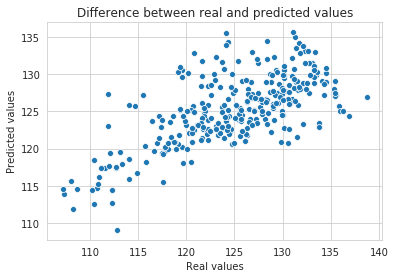

In [17]:
# Visualizar grafica comparativa de valores
# Se comparan los valores reales y los predichos
sns.scatterplot(x=y_test, y=predict_reg)
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.title('Difference between real and predicted values')
plt.show()

Como podemos observar, los valores predichos de las etiquetas tienden a crecer a medida que crecen los valores reales de las etiquetas. Este crecimiento parece ser lineal, pero al presentar errores en los valores predichos, no se tiene exactamente un crecimiento lineal perfecto, si no uno distorsionado. A pesar de esto, los valores predichos no dejan de estar bastante cerca de los reales.

Como conlusión a este apartado, hemos obtenido un valor de E$_{test}$ con el cuál hemos aproximado el valor de E$_{out}$. Hay que tener en cuenta que esta es una aproximación, y que el valor de E$_{out}$ puede ser incluso muy superior si la muestra que hemos escogido para ajustar nuestro modelo y la que hemos usado para realizar el test del ajuste no es representativa de la población (aunque para eso, habría que tener muy mala suerte). Además, es importante destacar que a medida que se vayan obteniendo más datos en training, mejor se podrá ajustar el modelo, y por tanto, el valor de E$_{out$} podrá verse reducido aún más (o incrementado en caso de que nuestro modelo produzca *overfitting*).

## Conclusiones finales

Vamos a cerrar este problema con unas conclusiones finales sobre el modelo que hemos seleccionado y ajustado posteriormente.

El modelo que hemos seleccionado ha sido el mejor de todos los que hemos evaluado. Hemos probado con modelos lineales más complejos que intentaban técnicas más avanzadas como por ejemplo la regularización o ajustar el mejor hiperplano dentro de un margen. Sin embargo, a pesar de lo sofisticado de las técnicas, el modelo que ha prevalecido, ante todo pronóstico, es el más simple, el que no utilizaba ninguna de estas técnicas. Es posible que, para este problema y para este conjunto de datos, la regularización no hubiese aportado mucho, ya que no parecía que hubiese mucha posibilidad de que se produjese *overfitting* al ajustar una recta (parece que hemos tenido una cantidad de datos suficiente). Intentar ajustar un hiperplano dentro de un margen es complicado, ya que hay que considerar bastantes hiperparámetros, como por ejemplo la anchura del margen o la ponderación que se le asigna al error de los puntos que caen fuera del margen.

El modelo seleccionado se ha ajustado muy bien a los datos, tanto a la hora de evaluarlo como en su posterior ajuste con todos los datos de training. Esto se ha podido observar en el hecho de que el error que de media se ha obtenido en la evaluación se ha visto reducido posteriormente en el ajuste con todos los datos. Por tanto, a medida que proporcionemos más datos a nuestro modelo, más aprenderá y mejor será capaz de generalizar.

En cuanto a su capacidad de generalizar, tal y como hemos dicho hace un momento, si seguimos proporcionando datos de entrenamiento al modelo podemos conseguir que se reduzca más el error fuera de la muestra (hasta cierto punto, obviamente). Además, tal y como se ve en la figura , parece que los datos tienen un comportamiento lineal. Por tanto, haber elegido un modelo lineal ha sido una buena idea, ya que con un número suficiente de datos, podemos obtener un error fuera de la muestra razonable con una capacidad de generalización buena, aunque podría quedarse limitada si los datos hubiesen presentado un comportamiento no lineal.

Es muy posible que al utilizar modelos no lineales nos encontrasemos con alguno que nos ofreciese unos mejores resultados (un menor error). Sin embargo, al estar restringidos a modelos lineales, no lo podremos saber con total seguridad.

Como pequeño resumen, nuestro modelo de Regresión Lineal ha dado muy buenos resultados en general y es el que mejor desempeño ha tenido de todos los modelos lineales que hemos probado. Puede ser que haya modelos no lineales que ofrezcan unos resultados superiores, eso sin dudarlo. Sin embargo, los resultados obtenidos, a pesar de ser un modelo tan simple, son muy buenos, y parece que aún queda margen de mejora.

# Problema de clasificación

## Descripción del problema

En este problema vamos a trabajar con el conjunto de datos *Optical Recognition of Handwritten Digits*. Este conjunto de datos ya ha sido preprocesado y contiene información sobre distintos dígitos manuscritos. Cada fila del conjunto de datos contiene 64 valores enteros que se encuentran en el rango $[0, 16]$ y un valor entero más que se encuentra en el rango $[0, 9]$, lo cuál se corresponde con el dígito manuscrito.

El motivo por el que se tienen 64 valores enteros de entrada es que los datos sin procesar eran *bitmaps* de $32 \times 32$ bits, en los que se representaba el dígito manuscrito. Cada bit representaba si se había escrito en esa posición (valor 1) o no (valor 0). Con el objetivo de reducir la cantidad de información, el *bitmap* se dividió en zonas de $4 \times 4$ bits, y para cada zona, se contaron el número de bits que tenían valor 1. Al hacer esta división, se obtuvieron 64 zonas (correspondientes a los 64 valores enteros de entrada), y el número de bits que podían valer 1 en esa zona iba de 0 a 16.

El conjunto de datos ya viene dividido en un conjunto de training y en un conjunto de test, con lo cuál no hará falta hacer una división de éste, cosa que si que pasaba en el anterior problema, donde solo teníamos un conjunto de datos.

## Análisis de los datos

Tal y como hacíamos en el problema anterior, vamos a comenzar con un análisis de los datos antes de pasar a hablar de qué modelo elegir o qué clase de funciones utilizar.

Lo primero que tenemos que hacer es cargar los datos, tanto los de training como los de test. Después de eso obtendremos de forma separada las características y las etiquetas. Además de eso, para ilustrar mejor como se representan los datos de entrada, vamos a mostrar los primeros valores del conjunto de training. Todo esto se puede ver a continuación:

In [18]:
# Leer los datos de training y test
train_df = read_data_values('datos/optdigits.tra')
test_df = read_data_values('datos/optdigits.tes')

# Separar las caracteristicas y las etiquetas
X_train, y_train = divide_data_labels(train_df)
X_test, y_test = divide_data_labels(test_df)

# Mostrar primeros valores del conjunto de training
display(test_df.head())

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


Sabiendo esto, a lo mejor nos podría interesar conocer si faltan datos, los rangos de los valores, etc. Ya sabemos los posibles valores que puede tomar cada característica y variable de salida, y según el repositorio no faltan datos, pero nunca está de más comprobar esto último, así que vamos a hacerlo tanto para el conjunto de traingin como para el test.

In [19]:
# Determinar si faltan valores para los dos conjunts
print('Missing values in train? ', train_df.isnull().values.any())
print('Missing values in test? ', test_df.isnull().values.any())

Missing values in train?  False
Missing values in test?  False


También nos podría interesar saber cómo están distribuidas las clases, es decir, ver si hay más elementos de una clase que de las otras o si en cambio están equilibrados. Para visualizarlo, podemos utilizar un diagrama de barras que nos permita ver cuántos valores de cada clase hay. Vamos a crear una función que nos permita visualizarlo:

In [20]:
def visualize_distribution(classes, values, columns):
    """
    Funcion para visualizar en un grafico de barras las
    clases con el numero de valores de cada una
    
    :param classes: Clases que se quieren representar
    :param values: Numero de elementos por clase
    :param columns: Nombres que dar a las clases y a los
                    numeros de elementos al pintar el grafico
    """
    
    # Crear DataFrame para mostrar el grafico
    df_plot = pd.DataFrame(columns=columns,
            data=[[v, l] for v, l in zip(classes, values)])
    
    # Crear grafico, poner titulo y mostrar
    sns.barplot(x=columns[0], y=columns[1], data=df_plot)
    plt.title('Number of samples per digit class')
    plt.show()

Y con esto, vamos a visualizar los datos de entrenamiento:

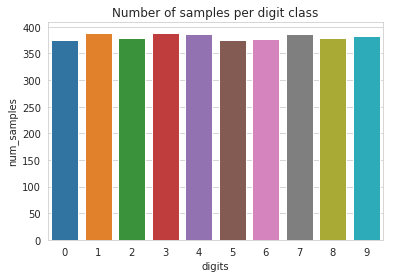

In [21]:
# Obtener las clases
classes = np.unique(train_df.values[:, -1])

# Obtener el numero de muestras por clase
num_elements = []

for i in classes:
    num_elements.append(np.where(y_train == i)[0].shape[0])

# Establecer nombres de los ejes [x, y]
axis = ['digits', 'num_samples']

# Visualizar grafico
visualize_distribution(classes, np.asarray(num_elements), axis)

Como podemos ver, el número de muestras para cada clase está muy equilibrado. Hay muy poca variabilidad entre el número de muestras de cada clase, y por tanto, cada una de ellas está muy bien representada (no hay una clase que tenga muchísimas más muestras que el resto).

En este problema tenemos demasiadas dimensiones como para poder realizar un análisis más profundo de los datos. Hacer un análisis de correlaciones sería un proceso demasiado costoso y engoroso, y por tanto no será llevado a cabo para este problema. Además, a simple vista, no parece que exista una auténtica correlación entre ninguna de las variables de entrada.

Así que, sabiendo que tenemos demasiadas dimensiones en este problema, la pregunta que nos vamos a hacer es: ¿existe alguna forma de reducir el número de dimensiones en este problema, sin perder demasiada capacidad para explicar los datos?

## Reducción de dimensionalidad

Para resoponer a la pregunta que nos hemos planteado anteriormente, vamos a intentar entender mejor lo que queremos conseguir. Nuestro objetivo es, a partir de los datos que disponemos, encontrar una forma de **reducir el número de dimensiones sin perder demasiada capacidad para explicar la varianza de los datos**. Es decir, queremos quedarnos con aquellas características que expliquen en mayor medida la varianza de los datos. Para ello, usaremos una técnica llamada PCA (Principal Component Analysis) que se basa en la descomposición en SVD. Con esta técnica transformaremos el espacio en el que estamos trabajando a uno en el que haya menos dimensiones, conservando un porcentaje alto de la varianza explicada (en torno a 90-95%). Cuantas más dimensiones se reduzcan, menos porcentaje de la varianza podremos explicar, así que hay que encontrar un equilibrio.

Hemos visto cómo podemos reducir la dimensionalidad. Sin embargo, no hemos contestado a otra pregunta muy importante: ¿por qué queremos reducir el número de dimensiones? Aparte de que los tiempos de cómputo bajarán, hay muchas características que no aportan realmente nada. Por ejemplo, las zonas del *bitmap* que conforman las esquinas pocas veces nos vana a dar información de qué dígito es el que se encuentra representado. También hay otras zonas que no aportan mucha información. Por tanto, queremos eliminar todas aquellas dimensiones "inútiles" que no sean capaces de ayudarnos a explicar los datos.

Una vez dicho esto, hace falta recalcar unos pequeños detalles. El primero es que aplicaremos la reducción de dimensionalidad a los datos de training **una vez elegido el modelo**, no antes (aplicaremos eso sí la reducción sobre los datos con los que entrenaremos y evaluaremos los modelos). El segundo es que PCA es una técnica muy susceptible a los valores de los datos de entrada. Por tanto, antes de reducir el número de dimensiones, tendremos que escalar los datos tal y como se hizo en el problema anterior.

## Selección de funciones

Antes de comentar los modelos que queremos evaluar, vamos a hablar brevemente de las funciones que utilizaremos.

Tal y como hicimos en el problema anterior, en este caso vamos a utilizar **combinaciones lineales** de los datos. No tiene mucho sentido realizar transformaciones no lineales sobre éstos ya que las características de los datos de entrada hacen referencia a la cantidad de valores 1 que hay en una zona del *bitmap*. Por tanto, añadir por ejemplo los cuadrados de los valores de entrada no parece que nos vaya a ayudar mucho y tampoco parece tener mucho sentido (¿qué significa que se eleve al cuadrado el número de bits de una zona?). Otro motivo muy importante por el que no se aplicarán transformaciones no lineales es que ya tenemos bastantes dimensiones, con lo cuál añadir más nos puede llegar a dar problemas (*overfitting*, más tiempo de entrenamiento, etc.).

## Selección de métricas

El último aspecto que vamos a comentar antes de pasar a hablar de los modelos que evaluaremos serán las métricas que utilizaremos tanto en el ajuste de los modelos como en su posterior evaluación.

### Métricas del ajuste

En el ajuste de los modelos utilizaremos dos métricas:

+ **Cross-Entropy**: utilizaremos esta métrica para el modelo que utiliza Regresión Logística Multinomial, ya que es la que normalmente se utiliza en los modelos de regresión logística. Como estamos trabajando con probabilidades, queremos minimizar el error que se comete al intentar predecir que un elemento pertenece a una clase determinada, así que esta es la métrica más adecuada en este caso.
+ **Hinge**: utilizaremos esta métrica para el modelo que utiliza SVM para clasificación, ya que es la que normalmente se utiliza en estos casos, debido a que mide tanto si se predice bien el resultado como si se deja margen suficiente.

### Métricas de evaluación

Para evaluar y comparar los ditintos modelos utilizaremos la precisión (tasa de aciertos, es decir, la tasa de elementos bien clasificados). El mejor modelo será el que tenga una precisión mayor que el resto, y dependiendo de como de alta sea, podremos decir si un modelo es bueno o malo. Se ha elegido esta métrica debido a que no nos interesa ver el error que cometemos, si no simplemente si estamos clasificando bien o no.

Adicionalmente, para el modelo definitivo, se usará también la matriz de confusión para ver mejor qué clases clasifica mejor que otras, con el objetivo de simplificar el análisis de los resultados obtenidos.

## Selección de modelos

Pasemos ahora a ver qué modelos vamos a utilizar en este problema. Antes de comentarlos, hace falta destacar que en este caso no utilizaremos el **perceptrón**, debido a que los datos pueden no ser linealmente separables (no lo sabemos con certeza, pero es probable que así sea) y a que necesitaríamos una gran cantidad de perceptrones para poder clasificar bien los datos. Probablemente con un MLP (Multilayer Perceptron) podríamos obtener unos buenos resultados. Sin embargo, estamos probando modelos lineales, y entre ellos no se encuentran las redes neuronales.

Otra cosa que hace falta destacar es que **todos los modelos utilizarán regularización**, la cuál será la norma $\ell 2$. Esto se debe tanto a que el módulo que estamos utilizando (scikit-learn) no permite no utilizar regularización como a que en este problema la regularización puede ofrecer unos mejores resultados, ya que se intentará restringir el espacio con tal de obtener soluciones de mejor calidad y evitar el *overfitting*, lo cuál puede darse en este caso sin que nos demos cuenta con mucha facilidad si por ejemplo las clases no tienen la misma distribución (no hay un número de elementos similar en cada clase debido a que casi todos pertenecen a una de ellas, por ejemplo).

### Regresión Logística Multinomial

El primer modelo que evaluaremos será la Regresión Logística Multinomial, utilizando la función $softmax$ para obtener las probabilidades para clasificar. Se ha escogido este modelo porque es la generalización de la Regresión Logística para más de dos clases, debido a que solo se entrena un modelo (si usaramos Regresión Logística con criterio *One vs Rest* estaríamos entrenando múltiples modelos para ver cuál es el que da una mayor probabilidad de que pertenezca a esa clase) y debido a que la salida es mucho más interpretable, ya que se escoge la clases con mayor probabilidad, en vez de que cada modelo diga cuál es la probabilidad de pertenecer a una clase y cuál es la probabilidad de pertenecer a cualquiera de las otras.

### SVM con *kernel* lineal

El segundo modelo que evaluaremos será el SVM con *kernel* lineal. Hemos escogido este modelo a que se suele utilizar en problemas de clasificación debido a que busca encontrar la mejor separación entre las clases, intentando dejar el mayor margen posible entre las clases que pretende separar y minimizando la suma de las violaciones del margen (puntos que están entre el plano y el margen, a diferencia de SVM en regresión, donde se minimizaba los que caían fuera del margen). Esta última parte es controlada por un parámetro $C$ que pondera la suma de los errores, con lo cuál modificándolo se obtendrán unos u otros resultados. Este parámetro puede considerarse como la cantidad de regularización que se aplica al modelo, ya que un valor de $C$ más grande hará que se ajuste más a los datos limitando el número de puntos dentro del margen, pero hará que la amplitud de este sea más pequeña, y por tanto, generalizará peor; mientras que un valor de $C$ más pequeño hará que haya más puntos dentro del margen, pero la amplitu del margen será mayor, con lo cuál puede generalizar mejor.

## Elección del mejor modelo

Para elegir el mejor modelo, vamos a llevar a cabo un proceso casi idéntico al que hemos realizado anteriormente. 
Con el objetivo de evitar repetir información, vamos a describir cuál sería el procedimiento, destacando qué nuevas cosas tendríamos que hacer. Si aparece algún procedimiento que ya aparecía en el problema anterior, las justificaciones del por qué son las mismas. Con esto dicho, vamos a ver como sería el proceso.

Con el conjunto de entrenamiento, realizaremos un **10-fold cross-validation** para cada modelo. La principal diferencia en este problema es que, al tener que clasificar, nos interesaría que las particiones que se hagan, aparte de ser disjuntas como lo eran en el problema anterior, tienen que contener un número de elementos de cada clase proporcional al que hay en la muestra, ya que nos interesa que cada clase esté proporcionalmente representada en todas las particiones dependiendo del número de elementos que tenga.

Para cada uno de los folds habrá que escalar los datos con los que se vaya entrenar el modelo (con el mismo tipo de escalado que hacíamos antes), entrenar el modelo, escalar los datos con los que se evaluará y predecir y medir la precisión. Sin embargo, a diferencia del problema anterior, después de escalar los datos y antes de entrenar se aplicará la reducción de dimensionalidad con PCA intentando conservar el 95% de la varianza explicada.

Finalmente, se escogerá el mejor modelo y se entrenará con todo el conjunto de entrenamiento, aplicando las transformaciones necesarias. De ser necesario ajustar algún hiperparámetro, también se hará en este proceso.

Para cada modelo, vamos a ir probando un conjunto de hiperparámetros y vamos a ver qué resultados obtenemos en cada caso. Tanto para Regresión Logística Multinomial como para SVM vamos a probar en cada uno el parámetro $C$ (los dos lo tienen por igual) con los valores $0.01$, $0.1$, $1$ y $10$ (esto determinará menos o más regularización).

Tal y como hicimos antes, vamos a crear nuestros pipelines para cada uno de los modelos:

In [22]:
# Clasificador con SVM
from sklearn.svm import LinearSVC

# Regresion Logistica Multinomial
from sklearn.linear_model import LogisticRegression

# Metricas de evaluacion
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# k-fold con proporcion de clases
from sklearn.model_selection import StratifiedKFold

# Reduccion PCA
from sklearn.decomposition import PCA

def create_mlr_pipeline(c_list):
    """
    Funcion para crear una lista de pipelines con el
    modelo de Regresion Logistica Multinomial dados
    unos valores de C, aplicando antes un escalado
    y PCA con 95% de varianza explicada
    
    :param c_list: Lista de valores C. Un valor por
                   cada RLM del pipeline
    
    :return Devuelve una lista con los pipelines
    """
    
    # Crear lista de pipelines
    pipelines = []
    
    # Insertar nuevo pipeline
    for c in c_list:
        pipelines.append(
            make_pipeline(StandardScaler(), PCA(n_components=0.95),
                          LogisticRegression(multi_class='multinomial',
                                             solver='newton-cg',
                                             C=c, random_state=1)))
    
    return pipelines

def create_svmc_pipeline(c_list):
    """
    Funcion para crear una lista de pipelines con el
    modelo de SVM dados unos valores de C, aplicando 
    antes un escalado y PCA con 95% de varianza explicada
    
    :param c_list: Lista de valores C. Un valor por
                   cada SVM del pipeline
    
    :return Devuelve una lista con los pipelines
    """
    
    # Crear lista de pipelines
    pipelines = []
    
    # Insertar nuevo pipeline
    for c in c_list:
        pipelines.append(
            make_pipeline(StandardScaler(), PCA(n_components=0.95),
                          LinearSVC(C=c, random_state=1, loss='hinge')))
    
    return pipelines

Vamos a preparar ahora los modelos para poder evaluarlos:

In [23]:
# Crear lista de valores de C para los dos modelos
c_list = [0.01, 0.1, 1.0, 10.0]

# Crear los nombres de los modelos
model_names = ['MLR c=0.01', 'MLR c=0.1',
               'MLR c=1.0', 'MLR c=10.0',
               'SVMC c=0.01', 'SVMC c=0.1',
               'SVMC c=1.0', 'SVMC c=10.0']

# Crear 10-fold que conserva la proporcion
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Crear pipelines para cada modelo
mlr_pipe = create_mlr_pipeline(c_list)
svmc_pipe = create_svmc_pipeline(c_list)

# Juntar todos los pipelines en una lista con los modelos
models = mlr_pipe + svmc_pipe

In [24]:
import warnings
warnings.filterwarnings('ignore')

# Obtener valores medios y desviaciones de las evaluaciones
means, deviations = evaluate_models(models, X_train, y_train,
                                    cv=cv, metric='accuracy')

# Mostrar valores por pantalla
print_evaluation_results(model_names, means, deviations, 'Mean Accuracy')

Evaluation results for each model


,Mean Accuracy,Standard Deviation
MLR c=0.01,0.954227,0.007859
MLR c=0.1,0.963130,0.008728
MLR c=1.0,0.965722,0.005349
MLR c=10.0,0.959178,0.007581
SVMC c=0.01,0.943231,0.009276
SVMC c=0.1,0.952120,0.010128
SVMC c=1.0,0.957346,0.011315
SVMC c=10.0,0.954200,0.007487
